In [12]:
from growth import model, integrate, viz
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

consts=model.load_constants()

### Setup and ODE integration

In [13]:
# Load constants and parameters
phi_O=consts['phi_O']
gamma_max=consts['gamma_max']
Kd_cpc=consts['Kd_cpc']
Kd_cnt=consts['Kd_cnt']
Y=consts['Y']
nu_max=20
consts['nu_max']=nu_max
f_a=1
m_Rb=consts['m_Rb']
m_phage=30*10**6/110 # Dalton mass of viral proteome / (Dalton mass of 1 a.a.)
phi_Ph_vals=np.linspace(0,1,11) # Generate Phi phage values

In [14]:
# Set nu_max values based on Chure et Cremer eLife 2023 Fig 1c
nu_max_vals = [0.01,0.05,0.1,0.5,1,5,10,20]

out=[]
for nu_max in nu_max_vals:
    # Set inital steady state conditions
    phi_O_ss=consts['phi_O']
    phi_Rb_ss=model.phiRb_optimal_allocation(gamma_max,nu_max,Kd_cpc,phi_O_ss)
    phi_Mb_ss=1-phi_O_ss-phi_Rb_ss
    c_pc=model.steady_state_precursors(gamma_max, phi_Rb_ss, nu_max, Kd_cpc, phi_O_ss)
    M0=1e9
    init_params = [M0,M0*phi_O_ss,M0*phi_Rb_ss,M0*phi_Mb_ss,0,c_pc,1]

    # Integrate ODEs for each phi_Ph value
    out_vars=['M','M_O','M_Rb','M_Mb','M_Ph','c_pc','c_nt'] # variable names for the variables integrated over time
    out_=[]


    for phi_Ph in phi_Ph_vals:
        

        # Set new allocations proportionally to initial SS optimal allocation
        phi_O = phi_O_ss*(1-phi_Ph)
        phi_Rb = phi_Rb_ss*(1-phi_Ph)
        phi_Mb = phi_Mb_ss*(1-phi_Ph)

        # Integration parameters
        max_time = 30
        dt=0.0001
        

        # Perform integration and store results in out
        time = np.arange(0, max_time, dt)
        out_ += [scipy.integrate.odeint(model.self_replicator_lytic_phage, 
                        init_params, 
                        time,args=(gamma_max,nu_max,Y,phi_Rb,phi_Mb,phi_Ph,Kd_cpc,Kd_cnt))]
    out+=[out_]

In [15]:
# Create dataframe to store results of ODE integration
df=pd.DataFrame()
for h in range(len(nu_max_vals)):
    df_=pd.DataFrame()
    for i in range(len(phi_Ph_vals)):
        _df=pd.DataFrame()
        _df['time']=np.linspace(0,max_time,int(max_time/dt))
        for j in range(len(out_vars)):
            _df[out_vars[j]]=out[h][i][:,j]
        _df['phi_Ph_val']=phi_Ph_vals[i]
        df_=pd.concat([df_,_df])
    df_['nu_max_val']=nu_max_vals[h]
    df=pd.concat([df,df_])

# Print dataframe column names
df.columns

Index(['time', 'M', 'M_O', 'M_Rb', 'M_Mb', 'M_Ph', 'c_pc', 'c_nt',
       'phi_Ph_val', 'nu_max_val'],
      dtype='object')

Text(0.5, 1.0, '$\\nu_{max}$ = 10.00')

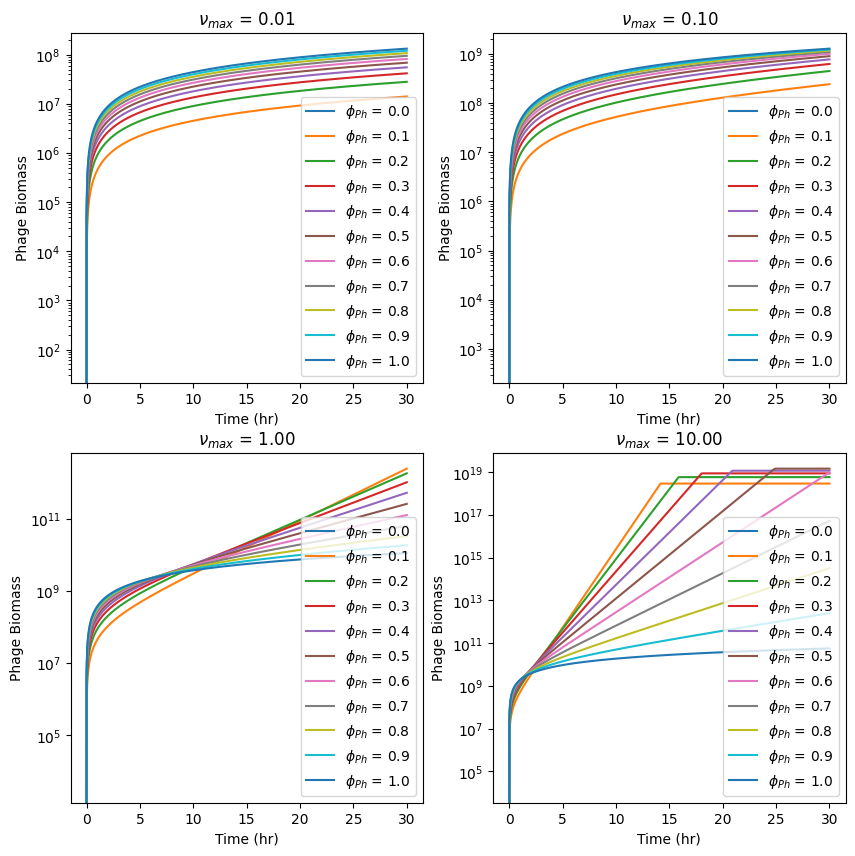

In [31]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
nu_max=nu_max_vals[0]
for phi in phi_Ph_vals:
    x_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].time
    y_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.title('$\\nu_{max}$ = %.2f'%(nu_max))

plt.subplot(2,2,2)
nu_max=nu_max_vals[2]
for phi in phi_Ph_vals:
    x_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].time
    y_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.title('$\\nu_{max}$ = %.2f'%(nu_max))

plt.subplot(2,2,3)
nu_max=nu_max_vals[4]
for phi in phi_Ph_vals:
    x_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].time
    y_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.title('$\\nu_{max}$ = %.2f'%(nu_max))

plt.subplot(2,2,4)
nu_max=nu_max_vals[-2]
for phi in phi_Ph_vals:
    x_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].time
    y_val=df.loc[(df.nu_max_val==nu_max)&(df.phi_Ph_val==phi)].M_Ph
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))
plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass')
plt.yscale('log')
plt.title('$\\nu_{max}$ = %.2f'%(nu_max))


#plt.xlim([1e-2,3e1]);

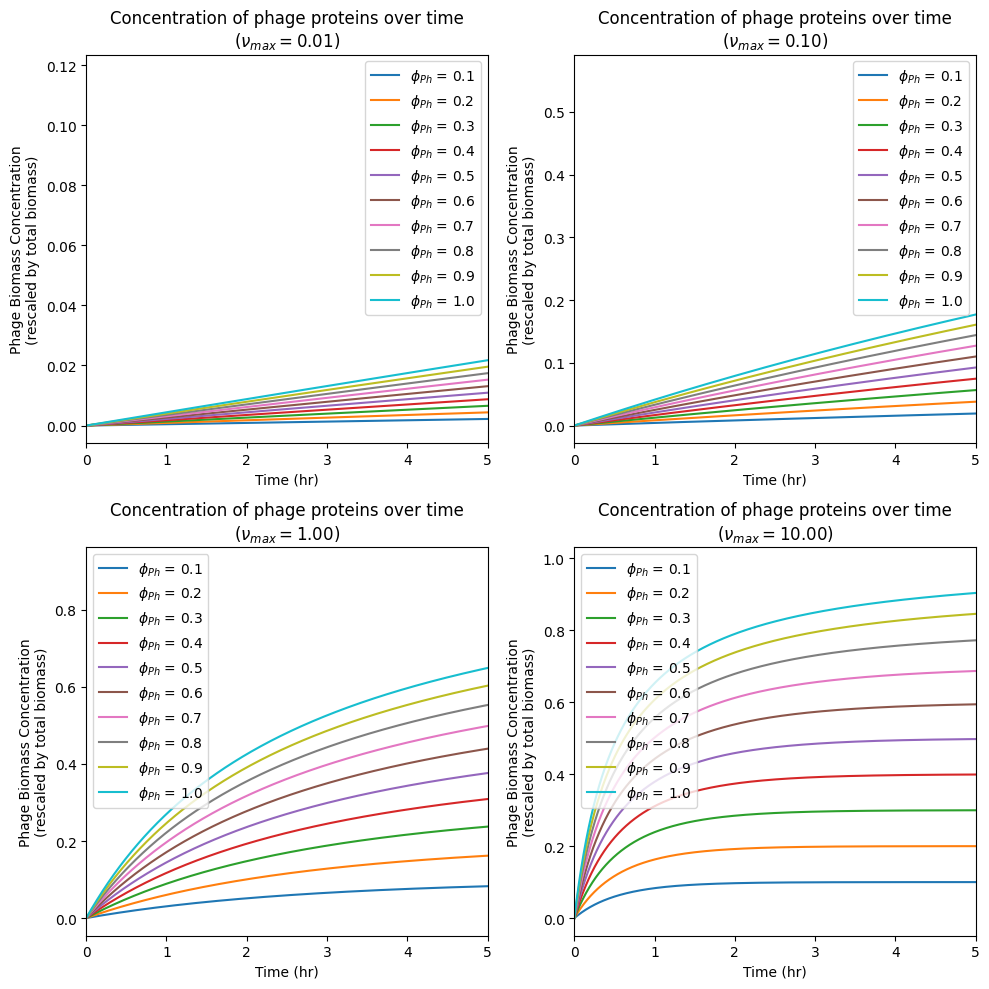

In [36]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
nonzero_phi_Ph_vals = np.delete(df.phi_Ph_val.unique(),0)
nu_max=nu_max_vals[0]
for phi in nonzero_phi_Ph_vals:
    x_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].time
    y_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M_Ph/df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass Concentration\n(rescaled by total biomass)')
plt.title('Concentration of phage proteins over time\n($\\nu_{max} = %.2f$)'%(nu_max))
plt.xlim([0,5]);

plt.subplot(2,2,2)
nonzero_phi_Ph_vals = np.delete(df.phi_Ph_val.unique(),0)
nu_max=nu_max_vals[2]
for phi in nonzero_phi_Ph_vals:
    x_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].time
    y_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M_Ph/df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass Concentration\n(rescaled by total biomass)')
plt.title('Concentration of phage proteins over time\n($\\nu_{max} = %.2f$)'%(nu_max))
plt.xlim([0,5]);

plt.subplot(2,2,3)
nonzero_phi_Ph_vals = np.delete(df.phi_Ph_val.unique(),0)
nu_max=nu_max_vals[4]
for phi in nonzero_phi_Ph_vals:
    x_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].time
    y_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M_Ph/df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass Concentration\n(rescaled by total biomass)')
plt.title('Concentration of phage proteins over time\n($\\nu_{max} = %.2f$)'%(nu_max))
plt.xlim([0,5]);

plt.subplot(2,2,4)
nonzero_phi_Ph_vals = np.delete(df.phi_Ph_val.unique(),0)
nu_max=nu_max_vals[-2]
for phi in nonzero_phi_Ph_vals:
    x_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].time
    y_val=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M_Ph/df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)].M
    plt.plot(x_val,y_val,label='$\phi_{Ph}$ = %.1f'%(phi))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('Phage Biomass Concentration\n(rescaled by total biomass)')
plt.title('Concentration of phage proteins over time\n($\\nu_{max} = %.2f$)'%(nu_max))
plt.xlim([0,5]);

plt.tight_layout()

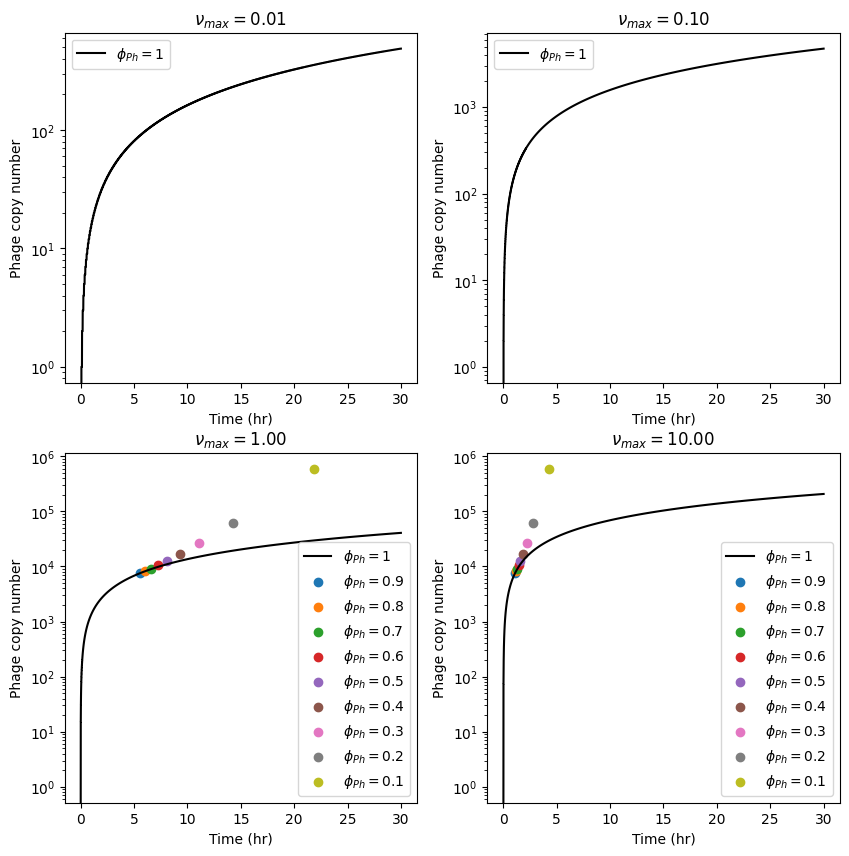

In [52]:
plt.figure(figsize=(10,10))


a=1
for nu_max in [nu_max_vals[0],nu_max_vals[2],nu_max_vals[4],nu_max_vals[-2]]:
    burst_size_match = []
    time_match = []
    phi_val = []
    phi_prev=1
    phi_Ph_vals_reverse=phi_Ph_vals[::-1]
    for phi in phi_Ph_vals_reverse:
        df_prev_phi=df.loc[(df.phi_Ph_val==phi_prev)&(df.nu_max_val==nu_max)]
        df_current_phi=df.loc[(df.phi_Ph_val==phi)&(df.nu_max_val==nu_max)]
        for t_ in range(len(df.time.unique())):
            if df_current_phi.M_Ph[t_] > df_prev_phi.M_Ph[t_]: # Check if current allocation has surpassed previous allocation in terms of phage biomass
                burst_size_match +=[df_current_phi.M_Ph[t_]//m_phage]
                time_match +=[df.time.unique()[t_]]
                phi_val +=[phi]
                phi_prev=phi
                break

    plt.subplot(2,2,a)
    x_val=df.time.unique()
    y_val=df.loc[(df.phi_Ph_val==1)&(df.nu_max_val==nu_max)].M_Ph //m_phage
    plt.plot(x_val,y_val,color='k',label='$\phi_{Ph} = 1$') # plot curve for phi = 1 strategy
    for i in range(len(time_match)):
        plt.scatter(time_match[i],burst_size_match[i],label='$\phi_{Ph} = %.1f$'%(phi_val[i])) # Plot individual points for 

    plt.xlabel('Time (hr)')
    plt.ylabel('Phage copy number')
    plt.title('$\\nu_{max} = %.2f$'%(nu_max))
    plt.yscale('log')
    #plt.ylim([1e2,1e6])
    #plt.xlim([0,5])
    plt.legend()
    a+=1